# Data Exploration

In this notebook, we load the KITTI dataset and explore the data.

In [36]:
# Import statements.
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Dict, Any, List, Optional, Tuple

In [5]:
# Global constants.
KITTI_ROOT_DIR = os.path.join('..', 'data', 'KITTI')
LEFT_CAM_ROOT_DIR = os.path.join(KITTI_ROOT_DIR, 'data_object_image_2')
TRAIN_IMAGE_DIR = os.path.join(LEFT_CAM_ROOT_DIR, 'training', 'image_2')
TEST_IMAGE_DIR = os.path.join(LEFT_CAM_ROOT_DIR, 'testing', 'image_2')
DEFAULT_DATASET_ARGS = {'val_split': 0.3}
TRAIN_KEY = 'train'
VAL_KEY = 'val'
TEST_KEY = 'test'

In [17]:
def get_partition(train_image_dir: str,
                  test_image_dir: str, dataset_args: Dict[str, Any] =
                  DEFAULT_DATASET_ARGS) -> Dict[str,List[str]]:
    """Returns a dict where the keys are 'train', 'test', and 'val', and the
    values are the images under each. The list is the authoratative order of the
    train/test examples; partition['train'][0] is the first training example,
    and x_train[0] will correspond with that filename.
    :param train_image_dir: The directory in which are located all the training
    images.
    :param test_image_dir: The directory in which are located all the test
    images.
    :param dataset_args: The dataset arguments. See DEFAULT_DATASET_ARGS for
    available options.
    :return: The train/val/test partition.
    """
    dataset_args = {**DEFAULT_DATASET_ARGS, **dataset_args}
    partition = {}
    train_image_filenames = [filename for
                             filename in os.listdir(train_image_dir) if
                             filename.endswith('.png')]
    rand_indices = np.random.permutation(len(train_image_filenames))
    split_index = int(dataset_args['val_split'] * len(train_image_filenames))
    val_indices = rand_indices[:split_index]
    train_indices = rand_indices[split_index:]
    partition[TRAIN_KEY] = [train_image_filenames[i] for i in train_indices]
    partition[VAL_KEY] = [train_image_filenames[i] for i in val_indices]
    test_image_filenames = [filename for
                            filename in os.listdir(test_image_dir) if
                            filename.endswith('.png')]
    partition[TEST_KEY] = test_image_filenames
    return partition

In [45]:
def load_image_into_numpy_array(
    path: str,
    target_size: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """Load an image from file into a numpy array.
    :param path: The path to the image.
    :param target_size: If specified, the width and height of the output array.
    If None, the image is size is unchanged.
    :return: The image contents as an np.ndarray of type uint8.
    """
    img_data = cv2.imread(path)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    if target_size:
        img_data = cv2.resize(img_data, target_size)
    return img_data.astype(np.uint8)

In [46]:
def display_image(filename: str) -> None:
    """Displays the image at filename.
    :param filename: The path to the image.
    """
    plt.imshow(load_image_into_numpy_array(filename))

In [18]:
partition = get_partition(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR)
print('{0} train images'.format(len(partition[TRAIN_KEY])))
print('{0} val images'.format(len(partition[VAL_KEY])))
print('{0} test images'.format(len(partition[TEST_KEY])))

5237 train images
2244 val images
7518 test images


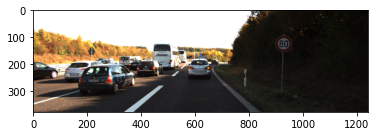

In [47]:
display_image(os.path.join(TRAIN_IMAGE_DIR, partition[TRAIN_KEY][0]))